In [1]:
import numpy as np
np.random.seed(2345)

import pandas as pd

In [2]:
questions = pd.read_csv("./Questions.csv", encoding='latin1')
answers = pd.read_csv("./Answers.csv", encoding='latin1')
tags = pd.read_csv("./Tags.csv", encoding='latin1')

In [3]:
tags.head()

,Id,Tag
0,77434,vector
1,79709,memory
2,79709,function
3,79709,global-variables
4,79709,side-effects


In [4]:
answers.head()

,Id,OwnerUserId,CreationDate,ParentId,Score,IsAcceptedAnswer,Body
0,79741,3259.0,2008-09-17T03:43:22Z,79709,-1,False,<p>It's tough to say definitively without know...
1,79768,6043.0,2008-09-17T03:48:29Z,79709,5,False,<p>use variables in the outer function instead...
2,79779,8002.0,2008-09-17T03:49:36Z,79709,0,False,<p>Third approach: inner function returns a re...
3,79788,NaN,2008-09-17T03:51:30Z,79709,3,False,<p>It's not going to make much difference to m...
4,79827,14257.0,2008-09-17T03:58:26Z,79709,1,False,"<p>I'm not sure I understand the question, but..."


In [5]:
questions.head()

,Id,OwnerUserId,CreationDate,Score,Title,Body
0,77434,14008.0,2008-09-16T21:40:29Z,134,How to access the last value in a vector?,<p>Suppose I have a vector that is nested in a...
1,79709,NaN,2008-09-17T03:39:16Z,1,Worse sin: side effects or passing massive obj...,<p>I have a function inside a loop inside a fu...
2,95007,15842.0,2008-09-18T17:59:19Z,48,Explain the quantile() function in R,<p>I've been mystified by the R quantile funct...
3,103312,NaN,2008-09-19T16:09:26Z,4,How to test for the EOF flag in R?,<p>How can I test for the <code>EOF</code> fla...
4,255697,1941213.0,2008-11-01T15:48:30Z,3,Is there an R package for learning a Dirichlet...,<p>I'm looking for a an <code>R</code> package...


In [6]:
questions.info() # Id Title Body are used for constructing the dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147075 entries, 0 to 147074
Data columns (total 6 columns):
Id              147075 non-null int64
OwnerUserId     146129 non-null float64
CreationDate    147075 non-null object
Score           147075 non-null int64
Title           147075 non-null object
Body            147075 non-null object
dtypes: float64(1), int64(2), object(3)
memory usage: 6.7+ MB


In [7]:
answers.info() # OwnerUserId ParentId IsAcceptedAnswer are used for constructing the dataset, maybe score can be used in the future

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198592 entries, 0 to 198591
Data columns (total 7 columns):
Id                  198592 non-null int64
OwnerUserId         197964 non-null float64
CreationDate        198592 non-null object
ParentId            198592 non-null int64
Score               198592 non-null int64
IsAcceptedAnswer    198592 non-null bool
Body                198592 non-null object
dtypes: bool(1), float64(1), int64(3), object(2)
memory usage: 9.3+ MB


In [8]:
tags.info() # Id and Tag are useful

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241546 entries, 0 to 241545
Data columns (total 2 columns):
Id     241546 non-null int64
Tag    241485 non-null object
dtypes: int64(1), object(1)
memory usage: 3.7+ MB


**先处理questions，数据清洗**

In [9]:
# extract all the code part 
temp_code = questions['Body'].str.extractall(r'(<code>[^<]+</code>)')

In [10]:
temp_code.head()

0
  match                                                   
0 0                                  <code>length()</code>
  1                                        <code>$#</code>
  2                       <code>dat$vec1$vec2[$#]\n</code>
  3      <code>dat$vec1$vec2[length(dat$vec1$vec2)]\n</...
1 0      <code>for (dataset in list_of_datasets) {\n  f...

In [11]:
# unstack and convert into a single column for cleaning
test = temp_code.unstack('match')

test.columns = test.columns.droplevel()
# put all columns together
code = pd.DataFrame(test.apply(lambda x: x.str.cat(), axis=1,reduce=True))
# rename 
code.columns = ['CodeBody']
# remove the html tags finally
code['CodeBody'] = code['CodeBody'].str.replace(r'<[^>]+>|\n|\r',' ')

In [12]:
# remove the code part from questions
body = questions['Body'].str.replace(r'<code>[^<]+</code>',' ')
# build up the question part from questions
questions['QuestionBody'] = body.str.replace(r"<[^>]+>|\n|\r", " ")

In [13]:
# Join the codebody by index
questions = questions.join(code)
# final cleaned dataset
questions_final = questions.drop('Body',axis=1)

In [14]:
questions_final.head()

,Id,OwnerUserId,CreationDate,Score,Title,QuestionBody,CodeBody
0,77434,14008.0,2008-09-16T21:40:29Z,134,How to access the last value in a vector?,Suppose I have a vector that is nested in a d...,length() $# dat$vec1$vec2[$#] dat$vec1$ve...
1,79709,NaN,2008-09-17T03:39:16Z,1,Worse sin: side effects or passing massive obj...,I have a function inside a loop inside a func...,for (dataset in list_of_datasets) { for (da...
2,95007,15842.0,2008-09-18T17:59:19Z,48,Explain the quantile() function in R,I've been mystified by the R quantile functio...,NaN
3,103312,NaN,2008-09-19T16:09:26Z,4,How to test for the EOF flag in R?,How can I test for the flag in R? For e...,"EOF f &lt;- file(fname, ""rb"") while (???) { ..."
4,255697,1941213.0,2008-11-01T15:48:30Z,3,Is there an R package for learning a Dirichlet...,I'm looking for a an package which can be u...,R R


In [15]:
questions_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147075 entries, 0 to 147074
Data columns (total 7 columns):
Id              147075 non-null int64
OwnerUserId     146129 non-null float64
CreationDate    147075 non-null object
Score           147075 non-null int64
Title           147075 non-null object
QuestionBody    147075 non-null object
CodeBody        134507 non-null object
dtypes: float64(1), int64(2), object(4)
memory usage: 7.9+ MB


**再处理tags,将其拼在questions后**

In [16]:
tags = tags[tags.Tag.notnull()]

In [17]:
tagsByquestion = tags.groupby('Id',as_index=False).agg(lambda x: ' '.join(x))

In [18]:
tagsByquestion.head()

,Id,Tag
0,77434,vector
1,79709,memory function global-variables side-effects
2,95007,math statistics
3,103312,file file-io eof
4,255697,math statistics bayesian dirichlet


In [19]:
tagsByquestion.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 121862 entries, 0 to 121861
Data columns (total 2 columns):
Id     121862 non-null int64
Tag    121862 non-null object
dtypes: int64(1), object(1)
memory usage: 2.8+ MB


In [20]:
questions_tags = questions_final.merge(tagsByquestion,on='Id',how='left')

In [21]:
questions_tags.head()

,Id,OwnerUserId,CreationDate,Score,Title,QuestionBody,CodeBody,Tag
0,77434,14008.0,2008-09-16T21:40:29Z,134,How to access the last value in a vector?,Suppose I have a vector that is nested in a d...,length() $# dat$vec1$vec2[$#] dat$vec1$ve...,vector
1,79709,NaN,2008-09-17T03:39:16Z,1,Worse sin: side effects or passing massive obj...,I have a function inside a loop inside a func...,for (dataset in list_of_datasets) { for (da...,memory function global-variables side-effects
2,95007,15842.0,2008-09-18T17:59:19Z,48,Explain the quantile() function in R,I've been mystified by the R quantile functio...,NaN,math statistics
3,103312,NaN,2008-09-19T16:09:26Z,4,How to test for the EOF flag in R?,How can I test for the flag in R? For e...,"EOF f &lt;- file(fname, ""rb"") while (???) { ...",file file-io eof
4,255697,1941213.0,2008-11-01T15:48:30Z,3,Is there an R package for learning a Dirichlet...,I'm looking for a an package which can be u...,R R,math statistics bayesian dirichlet


In [22]:
questions_tags.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 147075 entries, 0 to 147074
Data columns (total 8 columns):
Id              147075 non-null int64
OwnerUserId     146129 non-null float64
CreationDate    147075 non-null object
Score           147075 non-null int64
Title           147075 non-null object
QuestionBody    147075 non-null object
CodeBody        134507 non-null object
Tag             121862 non-null object
dtypes: float64(1), int64(2), object(5)
memory usage: 10.1+ MB


In [23]:
questions_tags = questions_tags.drop(['OwnerUserId','CreationDate','Score'], axis=1)

In [24]:
questions_tags.head()

,Id,Title,QuestionBody,CodeBody,Tag
0,77434,How to access the last value in a vector?,Suppose I have a vector that is nested in a d...,length() $# dat$vec1$vec2[$#] dat$vec1$ve...,vector
1,79709,Worse sin: side effects or passing massive obj...,I have a function inside a loop inside a func...,for (dataset in list_of_datasets) { for (da...,memory function global-variables side-effects
2,95007,Explain the quantile() function in R,I've been mystified by the R quantile functio...,NaN,math statistics
3,103312,How to test for the EOF flag in R?,How can I test for the flag in R? For e...,"EOF f &lt;- file(fname, ""rb"") while (???) { ...",file file-io eof
4,255697,Is there an R package for learning a Dirichlet...,I'm looking for a an package which can be u...,R R,math statistics bayesian dirichlet


In [25]:
questions_tags.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 147075 entries, 0 to 147074
Data columns (total 5 columns):
Id              147075 non-null int64
Title           147075 non-null object
QuestionBody    147075 non-null object
CodeBody        134507 non-null object
Tag             121862 non-null object
dtypes: int64(1), object(4)
memory usage: 6.7+ MB


**再处理answers，找出有最佳回答的问题**

In [26]:
accepted_answers = answers[answers.IsAcceptedAnswer == True]

In [27]:
accepted_answers.head()

,Id,OwnerUserId,CreationDate,ParentId,Score,IsAcceptedAnswer,Body
12,255992,23263.0,2008-11-01T19:29:54Z,255697,2,True,<p>I've only come across both R and the Dirich...
13,359458,3201.0,2008-12-11T14:06:56Z,359438,2,True,"<p>I have used <a href=""http://cran.r-project...."
15,440066,37751.0,2009-01-13T18:00:54Z,439526,8,True,<p>Clearly I should have worked on this for an...
18,455286,54904.0,2009-01-18T15:12:24Z,445059,7,True,<p>Here's what seems like another very R-type ...
19,467131,57626.0,2009-01-21T21:38:10Z,467110,11,True,<p>In most cases R is an interpreted language ...


In [28]:
accepted_answers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87661 entries, 12 to 198588
Data columns (total 7 columns):
Id                  87661 non-null int64
OwnerUserId         87404 non-null float64
CreationDate        87661 non-null object
ParentId            87661 non-null int64
Score               87661 non-null int64
IsAcceptedAnswer    87661 non-null bool
Body                87661 non-null object
dtypes: bool(1), float64(1), int64(3), object(2)
memory usage: 4.8+ MB


In [29]:
%matplotlib inline

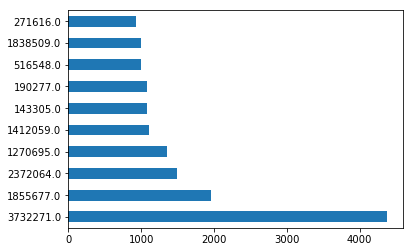

In [30]:
# Let's compute the number of best answers the experts have proposed:
accepted_answers["OwnerUserId"].value_counts().head(10).plot(kind="barh")

In [31]:
accepted_answers["OwnerUserId"].value_counts().head(10)

3732271.0    4380
1855677.0    1954
2372064.0    1495
1270695.0    1360
1412059.0    1102
143305.0     1083
190277.0     1075
516548.0      995
1838509.0     991
271616.0      927
Name: OwnerUserId, dtype: int64

In [32]:
accepted_answers = accepted_answers.drop(['Id','CreationDate','Score','IsAcceptedAnswer' ,'Body'], axis=1)

In [33]:
col_mapping = {'OwnerUserId' : 'ExpertId',
               'ParentId' : 'Id'}
accepted_answers = accepted_answers.rename(columns=col_mapping, copy = False)

In [34]:
accepted_answers.head()

,ExpertId,Id
12,23263.0,255697
13,3201.0,359438
15,37751.0,439526
18,54904.0,445059
19,57626.0,467110


In [35]:
accepted_answers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87661 entries, 12 to 198588
Data columns (total 2 columns):
ExpertId    87404 non-null float64
Id          87661 non-null int64
dtypes: float64(1), int64(1)
memory usage: 2.0 MB


In [36]:
accepted_answers = accepted_answers.dropna()

In [37]:
accepted_answers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87404 entries, 12 to 198588
Data columns (total 2 columns):
ExpertId    87404 non-null float64
Id          87404 non-null int64
dtypes: float64(1), int64(1)
memory usage: 2.0 MB


In [38]:
unique_expert = accepted_answers.ExpertId.unique()

In [39]:
unique_expert.shape

(9004L,)

In [54]:
count = accepted_answers['ExpertId'].value_counts()

In [55]:
count_df = pd.DataFrame(count)

In [56]:
count_df = count_df.reset_index()

In [57]:
count_df

,index,ExpertId
0,3732271.0,4380
1,1855677.0,1954
2,2372064.0,1495
3,1270695.0,1360
4,1412059.0,1102
5,143305.0,1083
6,190277.0,1075
7,516548.0,995
8,1838509.0,991
9,271616.0,927


In [58]:
col_mapping2 = {'ExpertId' : 'Count',
                'index' : 'ExpertId'}
count_df = count_df.rename(columns=col_mapping2, copy = False)

In [59]:
count_df

,ExpertId,Count
0,3732271.0,4380
1,1855677.0,1954
2,2372064.0,1495
3,1270695.0,1360
4,1412059.0,1102
5,143305.0,1083
6,190277.0,1075
7,516548.0,995
8,1838509.0,991
9,271616.0,927


**整合数据**

In [60]:
questions_answers = questions_tags.merge(accepted_answers,on='Id',how='right')

In [61]:
type(questions_answers)

pandas.core.frame.DataFrame

In [62]:
questions_answers.head()

,Id,Title,QuestionBody,CodeBody,Tag,ExpertId
0,95007,Explain the quantile() function in R,I've been mystified by the R quantile functio...,NaN,math statistics,79513.0
1,255697,Is there an R package for learning a Dirichlet...,I'm looking for a an package which can be u...,R R,math statistics bayesian dirichlet,23263.0
2,359438,Optimization packages for R,Does anyone know of any optimization packages...,NaN,mathematical-optimization,3201.0
3,439526,Thinking in Vectors with R,I know that R works most efficiently with vec...,st p1 p2 st&lt;-NULL p1&lt;-NULL p2&lt;-NU...,vector,37751.0
4,445059,Vectorize my thinking: Vector Operations in R,So earlier I answered my own question on thin...,for (j in my.data$item[my.data$fixed==0]) { #...,vector,54904.0


In [63]:
questions_answers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87404 entries, 0 to 87403
Data columns (total 6 columns):
Id              87404 non-null int64
Title           87404 non-null object
QuestionBody    87404 non-null object
CodeBody        81701 non-null object
Tag             71861 non-null object
ExpertId        87404 non-null float64
dtypes: float64(1), int64(1), object(4)
memory usage: 4.7+ MB


In [64]:
experts_count = questions_answers.merge(count_df, on='ExpertId', how='left')

In [65]:
experts_count.head()

,Id,Title,QuestionBody,CodeBody,Tag,ExpertId,Count
0,95007,Explain the quantile() function in R,I've been mystified by the R quantile functio...,NaN,math statistics,79513.0,1
1,255697,Is there an R package for learning a Dirichlet...,I'm looking for a an package which can be u...,R R,math statistics bayesian dirichlet,23263.0,1
2,359438,Optimization packages for R,Does anyone know of any optimization packages...,NaN,mathematical-optimization,3201.0,1
3,439526,Thinking in Vectors with R,I know that R works most efficiently with vec...,st p1 p2 st&lt;-NULL p1&lt;-NULL p2&lt;-NU...,vector,37751.0,53
4,445059,Vectorize my thinking: Vector Operations in R,So earlier I answered my own question on thin...,for (j in my.data$item[my.data$fixed==0]) { #...,vector,54904.0,1


In [139]:
experts_count=experts_count.iloc[:70000]

In [70]:
final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67176 entries, 3 to 87403
Data columns (total 7 columns):
Id              67176 non-null int64
Title           67176 non-null object
QuestionBody    67176 non-null object
CodeBody        63348 non-null object
Tag             54534 non-null object
ExpertId        67176 non-null float64
Count           67176 non-null int64
dtypes: float64(1), int64(2), object(4)
memory usage: 4.1+ MB


In [71]:
final_unique_expert = final.ExpertId.unique()
final_unique_expert.shape

(508L,)

In [162]:
import pickle
pickle.dump(df,open('qa.pkl','wb'))

In [74]:
df['ExpertId']=np.array(df['ExpertId']).astype(np.int32)

NameError: name 'df' is not defined

In [47]:
db=df['ExpertId'].value_counts()

# 搭建模型

In [75]:
import sys
sys.path.append('d:/miniconda/lib/site-packages')
import jieba
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.cross_validation import StratifiedShuffleSplit,StratifiedKFold,cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB,BernoulliNB,GaussianNB
import pickle

D:\miniconda\envs\python27\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [76]:
df=pd.read_pickle('qa.pkl')

In [175]:
df=df.fillna('none')

In [133]:
tfv = TfidfVectorizer(min_df=3,max_df=0.95,sublinear_tf=True)
x_title = tfv.fit_transform(df['Title'])
x_q=tfv.fit_transform(df['QuestionBody'])
x_tag=tfv.fit_transform(df['Tag'])

In [204]:
df

,Id,Title,QuestionBody,CodeBody,Tag,ExpertId,Count,cate
0,95007,Explain the quantile() function in R,I've been mystified by the R quantile functio...,none,math statistics,79513.0,1,218
1,255697,Is there an R package for learning a Dirichlet...,I'm looking for a an package which can be u...,R R,math statistics bayesian dirichlet,23263.0,1,91
2,359438,Optimization packages for R,Does anyone know of any optimization packages...,none,mathematical-optimization,3201.0,1,15
3,439526,Thinking in Vectors with R,I know that R works most efficiently with vec...,st p1 p2 st&lt;-NULL p1&lt;-NULL p2&lt;-NU...,vector,37751.0,53,121
4,445059,Vectorize my thinking: Vector Operations in R,So earlier I answered my own question on thin...,for (j in my.data$item[my.data$fixed==0]) { #...,vector,54904.0,1,163
5,467110,Is R a compiled language?,I can't find it anywhere on the web (and I do...,none,language-features,57626.0,1,171
6,476342,Converting a localized date of the form 12-okt...,I have imported a time series with dates of t...,"test = c(""11-Feb-01"",""12-Feb-01"",""01-Mai-08""...",date,12677.0,2,54
7,476726,Filtering data in R,I have a CSV of file of data that I can load ...,read.csv() NULL DocID Anno1 Anno7 ...,filtering,58681.0,2,173
8,495744,Operating with time intervals like 08:00-08:15,I would like to import a time-series where th...,08:00-08:15 08:15-08:30 08:30-08:45,time-series,148801.0,2,370
9,498932,What's the easiest way to install 100s of file...,I have a standard c# application that acts as...,none,visual-studio setup-project,445.0,1,3


In [205]:
#final1=experts_count[experts_count.Count > 10]
#final2 = experts_count[experts_count.Count > 20]
#final3=experts_count[experts_count.Count > 30]
#final4 = experts_count[experts_count.Count > 40]
k1=df.Count > 10
k2=df.Count > 20
k3=df.Count > 30
k4=df.Count > 40

In [206]:
x_tag1=tfv.fit_transform(list(df[:80000][k1]['Tag'])+list(df[80000:]['Tag']))
x_tag2=tfv.fit_transform(list(df[:80000][k2]['Tag'])+list(df[80000:]['Tag']))
x_tag3=tfv.fit_transform(list(df[:80000][k3]['Tag'])+list(df[80000:]['Tag']))
x_tag4=tfv.fit_transform(list(df[:80000][k4]['Tag'])+list(df[80000:]['Tag']))
#x_tag2=tfv.fit_transform(df[:70000][k2]['Tag'])
#x_tag3=tfv.fit_transform(df[:70000][k3]['Tag'])
#x_title1=tfv.fit_transform(df[:70000][k1]['Title'])
#x_title2=tfv.fit_transform(df[:70000][k2]['Title'])
#x_title3=tfv.fit_transform(df[:70000][k3]['Title'])

D:\miniconda\envs\python27\lib\site-packages\ipykernel\__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
D:\miniconda\envs\python27\lib\site-packages\ipykernel\__main__.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
D:\miniconda\envs\python27\lib\site-packages\ipykernel\__main__.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()
D:\miniconda\envs\python27\lib\site-packages\ipykernel\__main__.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [211]:
final1=df[:80000][k1]
final2=df[:80000][k2]
final3=df[:80000][k3]
final4=df[:80000][k4]

D:\miniconda\envs\python27\lib\site-packages\ipykernel\__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
D:\miniconda\envs\python27\lib\site-packages\ipykernel\__main__.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
D:\miniconda\envs\python27\lib\site-packages\ipykernel\__main__.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()
D:\miniconda\envs\python27\lib\site-packages\ipykernel\__main__.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [144]:
from sklearn import preprocessing
le=preprocessing.LabelEncoder()
le.fit(df['ExpertId'])
le.classes_
a=le.transform(df['ExpertId'])

In [191]:
lr=LogisticRegression(C=2)
print ('1'+ 'tag')
lr.fit(x_tag1[:final1.shape[0]],df['cate'][:80000][k1])
y=lr.predict(x_tag1[final1.shape[0]:])
sklearn.metrics.accuracy_score(y,df['cate'][80000:])

1tag


0.10491840956102046

In [212]:
lr=LogisticRegression(C=2)
print ('1'+ 'tag')
lr.fit(x_tag1[:final1.shape[0]],df['cate'][:80000][k1])
y=lr.predict(x_tag1[final1.shape[0]:])
sklearn.metrics.accuracy_score(y,df['cate'][80000:])

1tag


0.11655861696380335

In [195]:
final2.shape[0]

54853

In [199]:
print ('2'+ 'tag')
lr.fit(x_tag2[:final2.shape[0]],df['cate'][:70000][k2])
y=lr.predict(x_tag2[final2.shape[0]:])
sklearn.metrics.accuracy_score(y,df['cate'][70000:])

2tag


0.10422891289358768

In [200]:
print ('3'+ 'tag')
lr.fit(x_tag3[:final3.shape[0]],df['cate'][:70000][k3])
y=lr.predict(x_tag3[final3.shape[0]:])
sklearn.metrics.accuracy_score(y,df['cate'][70000:])

3tag


0.1036543323373937

In [202]:
print ('4'+ 'tag')
lr.fit(x_tag4[:final4.shape[0]],df['cate'][:70000][k4])
y=lr.predict(x_tag4[final4.shape[0]:])
sklearn.metrics.accuracy_score(y,df['cate'][70000:])

4tag


0.10279246150310274

In [107]:
y=lr.predict(x_q[60000:])

In [108]:
import sklearn#f_svd+n,adj
sklearn.metrics.accuracy_score(y,a[60000:])

0.12722965440356745

In [111]:
from sklearn.naive_bayes import BernoulliNB  as BNL
bnl=BNL(alpha=0.2, binarize=0, class_prior=None, fit_prior=True)
bnl.fit(x_tag[:60000],a[:60000])

BernoulliNB(alpha=0.2, binarize=0, class_prior=None, fit_prior=True)

In [112]:
y=lr.predict(x_q[60000:])
sklearn.metrics.accuracy_score(y,a[60000:])

0.12722965440356745

**数据整合完毕，开始构造实验数据集**

In [36]:
expert_profile = questions_answers.groupby('ExpertId',as_index=True).agg(lambda x: ' '.join(x))

In [37]:
expert_profile.head()

,Title,QuestionBody
ExpertId,,
13.0,"R ""str"" equivalent in perl",How do you get the data structure of an objec...
337.0,Is there any command to exit R programming?,Is there any command that can be used to exit...
419.0,How to run PowerShell command in R?,"For example, this PowerShell command returns ..."
445.0,What's the easiest way to install 100s of file...,I have a standard c# application that acts as...
459.0,"Regular expression""\\|"" in strsplit",I wonder is equal to ? maybe is eq...


In [38]:
expert_profile.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 9004 entries, 13.0 to 7034800.0
Data columns (total 2 columns):
Title           9004 non-null object
QuestionBody    9004 non-null object
dtypes: object(2)
memory usage: 211.0+ KB


In [39]:
expert_profile2 = questions_answers.set_index(['ExpertId'], drop=True)

In [56]:
expert_profile2.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 87404 entries, 79513.0 to 903061.0
Data columns (total 5 columns):
Id              87404 non-null int64
Title           87404 non-null object
QuestionBody    87404 non-null object
CodeBody        81701 non-null object
Tag             71861 non-null object
dtypes: int64(1), object(4)
memory usage: 4.0+ MB
